<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/cleaner/BulkAnalyze_flankcorrcenter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image
import scipy
import time

def flankcorrcenter_arr(arr, windowsizes):
  padarr = np.array([0] + list(arr))
  arr_cumsum = np.cumsum(padarr)
  poscorrpvals = []
  for windowsize in windowsizes:
    smootharr = (arr_cumsum[windowsize:] - arr_cumsum[:-windowsize])
    croparr = arr[int((windowsize-1)/2.0):(len(arr)-((windowsize-1)-int((windowsize-1)/2.0)))]
    poscorrpval = scipy.stats.pearsonr(smootharr-croparr, croparr, alternative='greater').pvalue
    poscorrpvals.append(poscorrpval)
  return poscorrpvals

def flankcorrcenter_arrs(arrs, windowsizes):
  arrs_cumsum = np.pad(np.cumsum(arrs, axis=1), ((0,0),(1,0)))
  poscorrpvals = []
  for windowsize in windowsizes:
    smootharrs = (arrs_cumsum[:,windowsize:] - arrs_cumsum[:,:-windowsize])
    croparrs = arrs[:,int((windowsize-1)/2.0):(arrs.shape[1]-((windowsize-1)-int((windowsize-1)/2.0)))]
    xs = smootharrs-croparrs
    ys = croparrs
    poscorrpval_arr = np.array([scipy.stats.pearsonr(x, y, alternative='greater').pvalue
                                for (x,y) in zip(xs,ys)])
    poscorrpvals.append(poscorrpval_arr)
  return poscorrpvals

def perform_analysis(values, num_permutations):

  toreturndict = {}

  start = time.time()
  rng = np.random.RandomState(1234)
  rng_permutations = np.array([rng.permutation(values)
                               for i in range(num_permutations)])

  windowsizes = [3,5,7]

  flankcorrcenter_corrpvalsforwindows = flankcorrcenter_arr(values, windowsizes)
  flankcorrcenter_corrpvalsforwindows_permute = flankcorrcenter_arrs(rng_permutations, windowsizes)

  for windowsize, flankcorrcenter_corrpvals, flankcorrcenter_corrpvals_permute in zip(
      windowsizes, flankcorrcenter_corrpvalsforwindows, flankcorrcenter_corrpvalsforwindows_permute):
    pval_flankcorrcenter = np.mean(flankcorrcenter_corrpvals_permute <= flankcorrcenter_corrpvals)
    toreturndict['pval_flankcorrcenter_window'+str(windowsize)] = pval_flankcorrcenter

  return toreturndict



In [2]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs


In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import json
event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))

In [5]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt
import time

%cd /content/drive/MyDrive/GCP_data/

NUM_PERMUTATIONS = 1000

generalstats = {"test": [], "control1": [], "control2": [], "control3": [],
                "control4": [], "control5": [], "control6": []}
csm1_psanalysis = {"test": [], "control1": [], "control2": [], "control3": [],
                   "control4": [], "control5": [], "control6": []}
compositez_psanalysis = {"test": [], "control1": [], "control2": [],
                         "control3": [], "control4": [], "control5": [], "control6": []}

event_count = 0

dont_rerun_if_cache_file_exists = True #If False, rerun the call the perform_powerspectrum_analysis
cachesavefolder = "/content/drive/MyDrive/GCP_data/analysis/flankcorrcentercache_v20231030/"
!mkdir $cachesavefolder

for (event, event_name, pval) in event_metadata_list[:]:

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  for spanname in ['test', 'control1', 'control2', 'control3',
                           'control4', 'control5', 'control6']:
    print("span:", spanname)
    egg_values = np.load("extracted/"+event+"_"+spanname+"_eggvalues.npy")

    csm1, z_sum_eggs = get_chisquareminus1(egg_values)

    csm1_zscore = np.sum(csm1)/np.sqrt(2*len(csm1)) #variance of chi-squared with df=1 is 2

    spangeneralstats = {
      'csm1_zscore': csm1_zscore,
      'length': len(csm1)}
    generalstats[spanname].append(spangeneralstats)

    print(spanname, spangeneralstats)

    for signaltype,signal,signalsavedict in [#("csm1", csm1, csm1_psanalysis),
                                             ("compositez", z_sum_eggs, compositez_psanalysis)
                                             ]:
      start = time.time()
      saveprefix = cachesavefolder+"/"+event+"_"+spanname+"_"+signaltype+"_nperm-"+str(NUM_PERMUTATIONS)
      if (dont_rerun_if_cache_file_exists and os.path.exists(saveprefix+"_psanalysis.json")):
        ps_analysis = json.load(open(saveprefix+"_psanalysis.json"))
      else:
        ps_analysis = perform_analysis(signal, NUM_PERMUTATIONS)
        open(saveprefix+"_psanalysis.json",'w').write(json.dumps(ps_analysis))
      print(signaltype, ps_analysis, time.time()-start)
      signalsavedict[spanname].append(ps_analysis)


Streaming output truncated to the last 5000 lines.
control4 {'csm1_zscore': -1.2359766823030487, 'length': 86400}
compositez {'pval_flankcorrcenter_window3': 0.527, 'pval_flankcorrcenter_window5': 0.234, 'pval_flankcorrcenter_window7': 0.165} 0.7433991432189941
span: control5
control5 {'csm1_zscore': -1.552062926392241, 'length': 86400}
compositez {'pval_flankcorrcenter_window3': 0.623, 'pval_flankcorrcenter_window5': 0.777, 'pval_flankcorrcenter_window7': 0.684} 0.69024658203125
span: control6
control6 {'csm1_zscore': 0.2580229876085446, 'length': 86400}
compositez {'pval_flankcorrcenter_window3': 0.903, 'pval_flankcorrcenter_window5': 0.973, 'pval_flankcorrcenter_window7': 0.479} 0.6536264419555664

--------------------------------
Event Count: 186 Event207 India Train Crash 0.3348916644764913
span: test
test {'csm1_zscore': 0.42644539536607173, 'length': 18000}
compositez {'pval_flankcorrcenter_window3': 0.668, 'pval_flankcorrcenter_window5': 0.551, 'pval_flankcorrcenter_window7': 0

In [6]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_flankcorrcenter_controls1to6"

#save the results
#open(prefix+"_csm1_psanalysis.json","w").write(json.dumps(csm1_psanalysis, indent=4))
open(prefix+"_compositez_psanalysis.json","w").write(json.dumps(compositez_psanalysis, indent=4))

475104

In [7]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCP_data


In [8]:
import json
import numpy as np
import scipy

NUM_PERMUTATIONS = 1000

#load the pvals in case we want to remake the plots without rerunning the prev stuff
prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_flankcorrcenter_controls1to6"

event_metadata_list = json.load(open("/content/drive/MyDrive/GCP_data/event_metadata_list.json"))
#generalstats = json.load(open("/content/drive/MyDrive/GCP_data/analysis/generalstats.json"))

#csm1_psanalysis = json.load(open(prefix+"_csm1_psanalysis.json"))
compositez_psanalysis = json.load(open(prefix+"_compositez_psanalysis.json"))

In [9]:
import os

def get_meta_pval(pvals):
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

metatrends_to_sim = 5000
rng = np.random.RandomState(1234)
savefile = "/content/drive/MyDrive/GCP_data/analysis/simulated_metatrends_nperm"+str(metatrends_to_sim)+".npy"
if (os.path.isfile(savefile)):
  simulated_metapvals_arr = np.load(savefile)
else:
  simulated_metapvals_arr = np.array([
      get_iterative_metapvals(
        np.maximum(rng.uniform(size=len(event_metadata_list)),
                  1.0/NUM_PERMUTATIONS)
      )
        for i in range(metatrends_to_sim)])
  np.save(savefile, simulated_metapvals_arr)

In [14]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from IPython.core.display import Image, display

#plot how the meta pvalue changes with samples

min_meta = 1 # start the x axis here, min num to include in metaanalysis
max_meta = len(event_metadata_list) #where to stop the plot

def correct_pvals(pvals, m): #permutation p values should never be zero: https://www.degruyter.com/document/doi/10.2202/1544-6115.1585/html
  #'Let B be the number of times out of m that t_sim >= t_obs'
  Bs = pvals*m
  #Under the null hypothesis, B is uniformly distributed across all integers
  # ranging from 0 to m, and the probability of observing B <= b is (b+1)/(m+1)
  adjusted_pvals = (Bs+1)/(m+1)
  return adjusted_pvals

original_gcp_pvals = np.array([x[2] for x in event_metadata_list[:max_meta]])

def make_meta_trend_plot(title, uncorrected_pvals_loa, loa_names, loa_colors):
  %matplotlib inline

  xaxis_slice = list(range(min_meta,max_meta+1))
  xaxis_full = list(range(1,max_meta+1))

  pvals_loa = [correct_pvals(arr, m=NUM_PERMUTATIONS) for arr in uncorrected_pvals_loa]
  metapvals_loa = [get_iterative_metapvals(arr) for arr in pvals_loa]

  theslice = slice(min_meta-1, max_meta)
  min_simmetapvals_arr = np.min(simulated_metapvals_arr[:,theslice], axis=1)

  pvalformetapvals_list = [correct_pvals(np.mean(min_simmetapvals_arr <= np.min(arr)),
                                         m=len(simulated_metapvals_arr))
                            for arr in metapvals_loa]

  pvalforrankbias_list = [
      scipy.stats.mannwhitneyu(x=arr[original_gcp_pvals < 0.5],
                               y=arr[original_gcp_pvals >= 0.5], alternative='less')[1]
      for arr in pvals_loa
  ]
  print("Testing for low meta-analysis p-values:")
  for arr_name, metatrendpval, rankbiaspval in zip(loa_names, pvalformetapvals_list, pvalforrankbias_list):
    print("meta-analysis p-value:",arr_name,"pval:",metatrendpval)
    print("Rankbias p-value:",arr_name,"pval:",rankbiaspval)

  #Plot meta-analysis trends for the original pvalues
  fig = plt.figure(figsize=(15,4))
  handles = []

  plt.plot([min_meta, max_meta], -np.log10([np.percentile(min_simmetapvals_arr, 5)]*2), color="black", linestyle="--")
  plt.plot(xaxis_full, -np.log10(original_gcp_pvals), color="black")
  handles.append(mpatches.Patch(color='black', label='Original GCP -log10(pval)'))

  for pvals, metapvals, color, arr_name in zip(pvals_loa, metapvals_loa, loa_colors, loa_names):
    plt.scatter(xaxis_full, -np.log10(pvals[:max_meta]), color=color, s=1)
    plt.plot(xaxis_slice, -np.log10(metapvals[theslice]), color=color)
    handles.append(mpatches.Patch(color=color, label=arr_name))

  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("-log10 pvalue") #Z-score equivalent derived from inverse-normal-cdf(1-p)
  plt.title(title)
  plt.legend(handles=handles, loc="upper left", ncol=4)
  plt.show()

  return pvalformetapvals_list

print("num permutations:",NUM_PERMUTATIONS)

num permutations: 1000


compositez
flankcorrcenter_window3
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.8024395120975805
Rankbias p-value: Original Timeperiod pval: 0.22909230452415164
meta-analysis p-value: 1x before pval: 0.6956608678264347
Rankbias p-value: 1x before pval: 0.554600295294634
meta-analysis p-value: 1x after pval: 0.7540491901619676
Rankbias p-value: 1x after pval: 0.910984218513833
meta-analysis p-value: 2x before pval: 0.47370525894821036
Rankbias p-value: 2x before pval: 0.7966473444348479
meta-analysis p-value: 2x after pval: 0.242751449710058
Rankbias p-value: 2x after pval: 0.3802631862604812
meta-analysis p-value: 3x before pval: 0.5164967006598681
Rankbias p-value: 3x before pval: 0.8634722205294298
meta-analysis p-value: 3x after pval: 0.7614477104579084
Rankbias p-value: 3x after pval: 0.5118654915729571


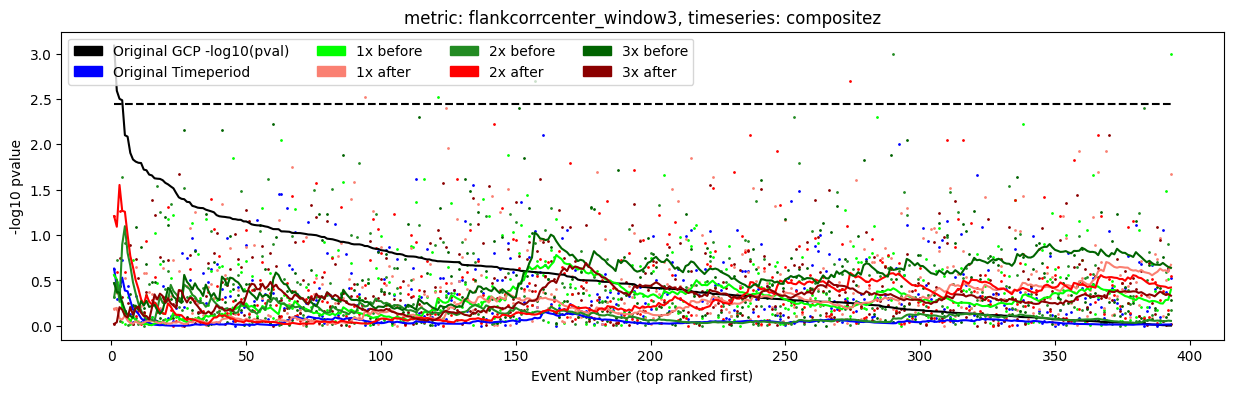

flankcorrcenter_window5
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.34233153369326136
Rankbias p-value: Original Timeperiod pval: 0.14334929413472897
meta-analysis p-value: 1x before pval: 0.29414117176564686
Rankbias p-value: 1x before pval: 0.9695380391485054
meta-analysis p-value: 1x after pval: 0.8952209558088382
Rankbias p-value: 1x after pval: 0.8713227635164716
meta-analysis p-value: 2x before pval: 0.6274745050989802
Rankbias p-value: 2x before pval: 0.7913005693274788
meta-analysis p-value: 2x after pval: 0.8226354729054189
Rankbias p-value: 2x after pval: 0.5400983220803875
meta-analysis p-value: 3x before pval: 0.47530493901219756
Rankbias p-value: 3x before pval: 0.9394883163872116
meta-analysis p-value: 3x after pval: 0.6866626674665067
Rankbias p-value: 3x after pval: 0.2659398497415634


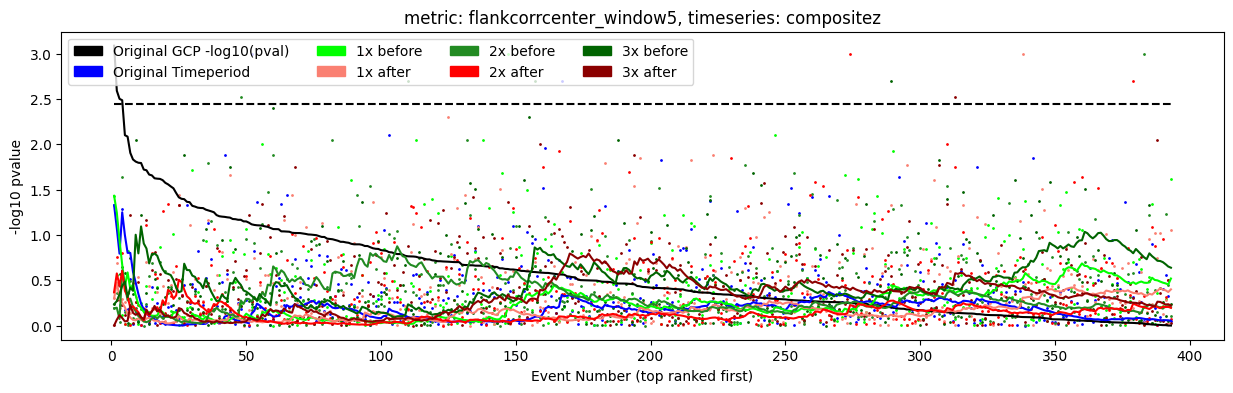

flankcorrcenter_window7
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.5476904619076185
Rankbias p-value: Original Timeperiod pval: 0.01501539266712262
meta-analysis p-value: 1x before pval: 0.3099380123975205
Rankbias p-value: 1x before pval: 0.9424482200526697
meta-analysis p-value: 1x after pval: 0.6634673065386922
Rankbias p-value: 1x after pval: 0.9035406991778678
meta-analysis p-value: 2x before pval: 0.9426114777044591
Rankbias p-value: 2x before pval: 0.5400982727007039
meta-analysis p-value: 2x after pval: 0.7104579084183164
Rankbias p-value: 2x after pval: 0.11026691824689838
meta-analysis p-value: 3x before pval: 0.6850629874025196
Rankbias p-value: 3x before pval: 0.9489917277574585
meta-analysis p-value: 3x after pval: 0.7212557488502299
Rankbias p-value: 3x after pval: 0.6673008086170324


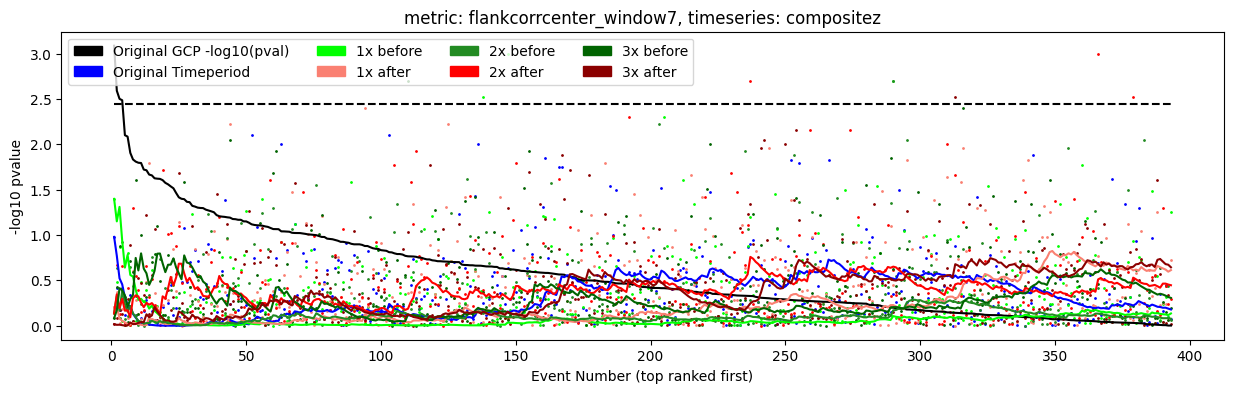

compositez
NEGATIVE flankcorrcenter_window3
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.367126574685063
Rankbias p-value: Original Timeperiod pval: 0.7711849111341715
meta-analysis p-value: 1x before pval: 0.30813837232553487
Rankbias p-value: 1x before pval: 0.4457614480341586
meta-analysis p-value: 1x after pval: 0.35692861427714456
Rankbias p-value: 1x after pval: 0.0891632953967475
meta-analysis p-value: 2x before pval: 0.020595880823835237
Rankbias p-value: 2x before pval: 0.2036115629779996
meta-analysis p-value: 2x after pval: 0.2615476904619076
Rankbias p-value: 2x after pval: 0.620085338092055
meta-analysis p-value: 3x before pval: 0.6052789442111578
Rankbias p-value: 3x before pval: 0.13672814265545086
meta-analysis p-value: 3x after pval: 0.30933813237352525
Rankbias p-value: 3x after pval: 0.48849949771957846


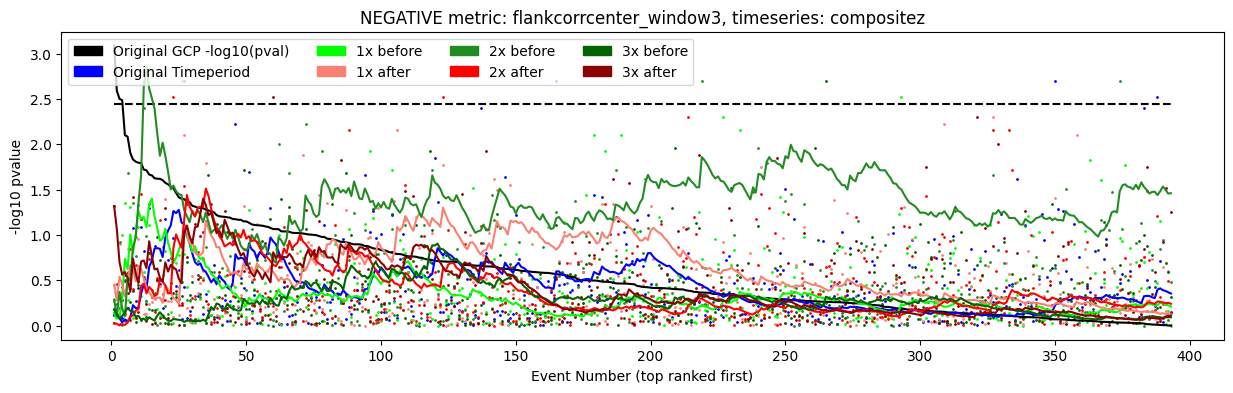

NEGATIVE flankcorrcenter_window5
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.08218356328734253
Rankbias p-value: Original Timeperiod pval: 0.856857614947615
meta-analysis p-value: 1x before pval: 0.3305338932213558
Rankbias p-value: 1x before pval: 0.030525086601640324
meta-analysis p-value: 1x after pval: 0.5566886622675465
Rankbias p-value: 1x after pval: 0.12886959285709393
meta-analysis p-value: 2x before pval: 0.08198360327934413
Rankbias p-value: 2x before pval: 0.2089623517648294
meta-analysis p-value: 2x after pval: 0.4259148170365927
Rankbias p-value: 2x after pval: 0.4602649947564079
meta-analysis p-value: 3x before pval: 0.17296540691861628
Rankbias p-value: 3x before pval: 0.06062152010741751
meta-analysis p-value: 3x after pval: 0.08218356328734253
Rankbias p-value: 3x after pval: 0.7343603987716909


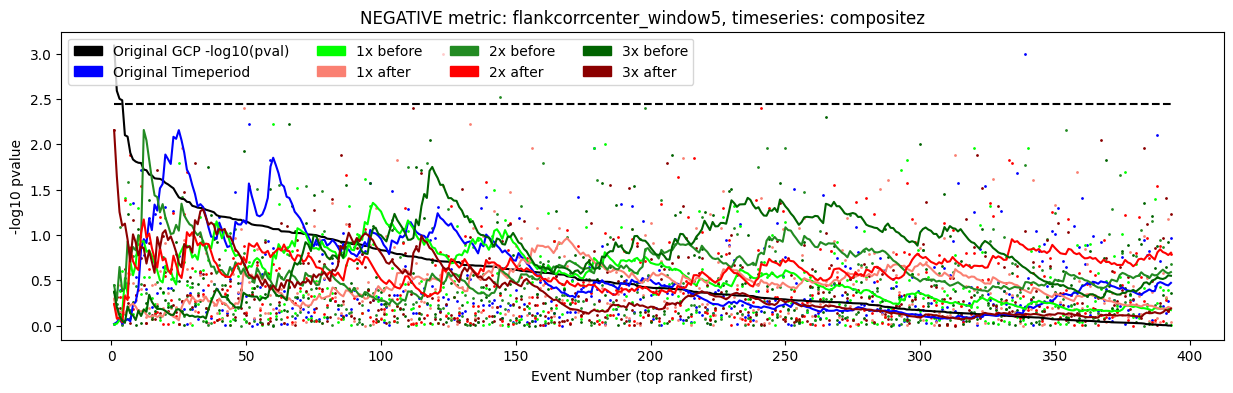

NEGATIVE flankcorrcenter_window7
Testing for low meta-analysis p-values:
meta-analysis p-value: Original Timeperiod pval: 0.2835432913417317
Rankbias p-value: Original Timeperiod pval: 0.9850192657273146
meta-analysis p-value: 1x before pval: 0.12297540491901619
Rankbias p-value: 1x before pval: 0.05765738025244555
meta-analysis p-value: 1x after pval: 0.33733253349330133
Rankbias p-value: 1x after pval: 0.09661583895350034
meta-analysis p-value: 2x before pval: 0.13737252549490103
Rankbias p-value: 2x before pval: 0.46026504369167415
meta-analysis p-value: 2x after pval: 0.5488902219556089
Rankbias p-value: 2x after pval: 0.8899053908355754
meta-analysis p-value: 3x before pval: 0.1201759648070386
Rankbias p-value: 3x before pval: 0.05110425592576327
meta-analysis p-value: 3x after pval: 0.13897220555888823
Rankbias p-value: 3x after pval: 0.33303180396406706


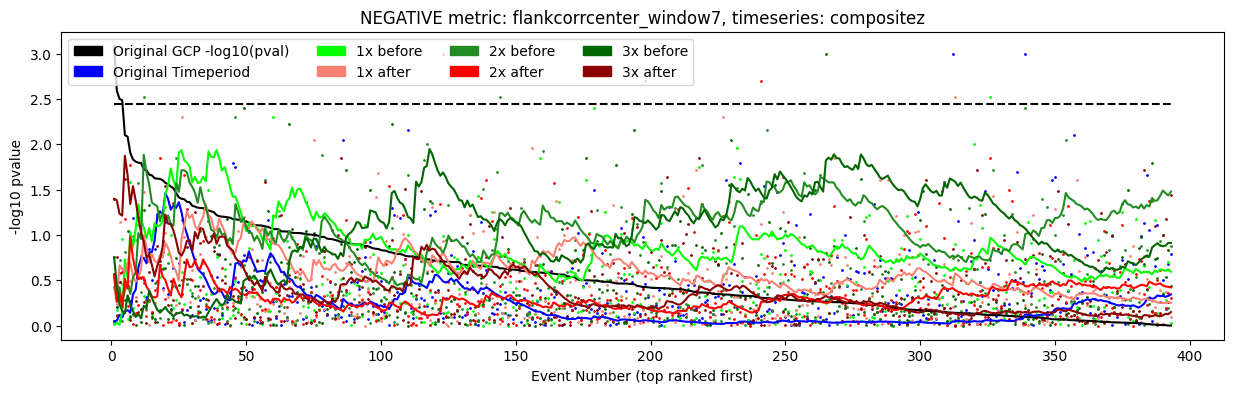

In [15]:
spannames = ['test', 'control1', 'control2', 'control3', 'control4', 'control5', 'control6']
loa_names = ['Original Timeperiod', '1x before', '1x after', '2x before', '2x after', '3x before', '3x after']
loa_colors = ['blue', 'lime', 'salmon', 'forestgreen', 'red', 'darkgreen', 'darkred']

all_metatrendplot_pvals = []

windows = ['3', '5', '7']
for signalname, pvals in [#('csm1', csm1_psanalysis),
                          ('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  for metricname in (['flankcorrcenter_window'+x for x in windows]):
    print(metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[np.array([x["pval_"+metricname] for x in pvals[y]])
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+metricname,
                                       pval) )

for signalname, pvals in [#('csm1', csm1_psanalysis),
                          ('compositez', compositez_psanalysis)
                          ]:
  print(signalname)
  for metricname in (['flankcorrcenter_window'+x for x in windows]):
    print("NEGATIVE", metricname)
    pval_for_trendplots_list = make_meta_trend_plot(
      "NEGATIVE metric: "+metricname+", timeseries: "+signalname,
      uncorrected_pvals_loa=[(1-np.array([x["pval_"+metricname] for x in pvals[y]]))
                             for y in spannames],
      loa_names=loa_names,
      loa_colors=loa_colors)
    for arr_name, pval in zip(loa_names, pval_for_trendplots_list):
      all_metatrendplot_pvals.append( ("span:"+arr_name+"; signal:"+signalname+"; metric:"+"negative-"+metricname,
                                       pval) )


In [16]:
[(x[0], x[1], (x[1]*len(all_metatrendplot_pvals) )/(i+1) )
  for (i,x) in enumerate(sorted(all_metatrendplot_pvals, key=lambda x: x[1]))]


[('span:2x before; signal:compositez; metric:negative-flankcorrcenter_window3',
  0.020595880823835237,
  0.8650269946010799),
 ('span:2x before; signal:compositez; metric:negative-flankcorrcenter_window5',
  0.08198360327934413,
  1.7216556688662268),
 ('span:Original Timeperiod; signal:compositez; metric:negative-flankcorrcenter_window5',
  0.08218356328734253,
  1.1505698860227953),
 ('span:3x after; signal:compositez; metric:negative-flankcorrcenter_window5',
  0.08218356328734253,
  0.8629274145170965),
 ('span:3x before; signal:compositez; metric:negative-flankcorrcenter_window7',
  0.1201759648070386,
  1.009478104379124),
 ('span:1x before; signal:compositez; metric:negative-flankcorrcenter_window7',
  0.12297540491901619,
  0.8608278344331133),
 ('span:2x before; signal:compositez; metric:negative-flankcorrcenter_window7',
  0.13737252549490103,
  0.8242351529694062),
 ('span:3x after; signal:compositez; metric:negative-flankcorrcenter_window7',
  0.13897220555888823,
  0.7296